# Correlation Analytics --- The Phillips curve

## Background

<p>The Phillips curve is an economic concept developed by A. W. Phillips describing the inverse relationship between unemployment rate and inflation rate within an economy. It states that economic growth brings inflation, leading to more jobs and hence lower unemployment rate.</p><br>
This report is going to validate this relationship using historical data in Hong Kong.

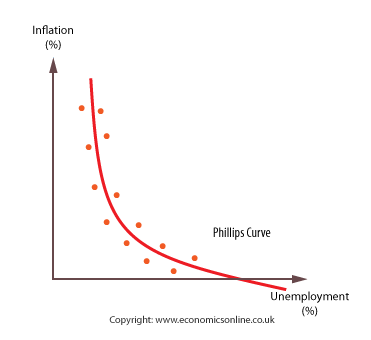

In [2]:
from IPython.display import Image
Image('Source Data\\Phillips-curve-basic.png')

Source:
<ul>
<li>http://www.investopedia.com/terms/p/phillipscurve.asp</li>
<li>https://en.wikipedia.org/wiki/Phillips_curve</li>
</ul>

## Data Extraction and Transformation

### Data Extraction

Inflation Rate:<br>
<p>Source:<br>https://data.gov.hk/en-data/dataset/hk-censtatd-tablechart-cpi/resource/927b192b-83ff-4c45-aa5a-cd970d6274a1<br>
This dataset contains the average monthly rate of change (%) of consumer price indices (CPI) during the latest 3 months from 1981 to 2017. There are 4 CPIs in the dataset. The CPI(A), CPI(B) and CPI(C) are compiled based on expenditure patterns of households (low, medium and high expenditure groups). The composite CPI aggregates the expenditure patterns covered by the above 3 indices, therefore it can better represent the whole household sector. In this report, the composite CPI will be used for estimating the true inflation rate of Hong Kong.</p>

Unemployment Rate:<br>
<p>Source:<br>https://data.gov.hk/en-data/dataset/hk-censtatd-tablechart-statistics-on-labour-force-unemployment-and-underemployment/resource/6f1045ff-097d-402a-9586-abba49cf468a<br>
This dataset contains the unemployment rate in 3-month period from 1982 to 2017. Since the seasonally adjusted CPI rate of change is used, the seasonally adjusted unemployment rate is also used in this report.</p>

### Data Transformation

In [3]:
# Import Pandas for data manipulation
import pandas as pd
# Set global display option
pd.options.display.max_rows = 15
# use pandas library to read excel file
df_cpi = pd.read_excel('Source Data\\Consumer Price Index.xlsx', parse_cols="A:C", skip_rows=3, header=3).iloc[0:439]
# display output
df_cpi

,Year,Month,Composite Consumer Price Index
0,1981,Jan,N.A.
1,NaN,Feb,N.A.
2,NaN,Mar,N.A.
3,NaN,Apr,N.A.
4,NaN,May,N.A.
5,NaN,Jun,N.A.
6,NaN,Jul,N.A.
...,...,...,...
432,2017,Jan,0.1
433,NaN,Feb,-0.1


As the Year Column is incomplete, it is needed to fill it in.

In [4]:
# Fill Year Column
Year = [int(df_cpi.Year.values[0])]
for i in range(1, len(df_cpi.index)):
	Year.append(Year[i-1] + int((i)%12==0))
df_cpi['Year'] = Year
df_cpi

,Year,Month,Composite Consumer Price Index
0,1981,Jan,N.A.
1,1981,Feb,N.A.
2,1981,Mar,N.A.
3,1981,Apr,N.A.
4,1981,May,N.A.
5,1981,Jun,N.A.
6,1981,Jul,N.A.
...,...,...,...
432,2017,Jan,0.1
433,2017,Feb,-0.1


In order to estimate the inflation rate, the year-to-year rate of change of CPI is used. In this dataset, the rate of change is on monthly basis. Some steps are involved for this data conversion.

In [5]:
# Import numpy for calculation
import numpy as np
# Drop rows with value 'n.a'
df_cpi = df_cpi[df_cpi['Composite Consumer Price Index']!='N.A.']
df_cpi = df_cpi.reset_index(drop=True)
# From % to float
df_cpi['Composite Consumer Price Index'] = df_cpi['Composite Consumer Price Index']/100 + 1
# Prepare array of yearly rate
cpi_monthly = list(df_cpi['Composite Consumer Price Index'].values)
cpi_yearly = []
for i in range(0, len(cpi_monthly)):
	if i <= 10:
		continue
	else:
		cpi_yearly.append((np.product(cpi_monthly[i-11:i+1])-1)*100)
# Drop first 11 rows and monthly rate column
df_cpi = df_cpi.iloc[11:len(df_cpi)]
df_cpi = df_cpi.drop('Composite Consumer Price Index',axis=1)
df_cpi = df_cpi.reset_index(drop=True)
# Copy array to dataframe
df_cpi['cpi_yearly'] = cpi_yearly
# Display Output
df_cpi

,Year,Month,cpi_yearly
0,1992,Dec,9.487854
1,1993,Jan,9.487854
2,1993,Feb,9.379343
3,1993,Mar,9.054454
4,1993,Apr,8.622555
5,1993,May,8.622555
6,1993,Jun,8.730423
...,...,...,...
289,2017,Jan,1.102990
290,2017,Feb,0.699788


Now the period is splited into two columns (Year and Month). These columns are merged into a column "Period" and stored in standard Python datetime format.

In [6]:
# Import Calendar and datetime library for converting data into standard datetime format
import calendar
import datetime

# Function to get last day of month of a year
def get_datetime(Year, Month):
	return datetime.date(int(Year),int(Month),calendar.monthrange(int(Year),int(Month))[1])

# Convert month appreviation to integer (e.g. "Dec" -> 12)
df_cpi['Month'] = df_cpi['Month'].apply(lambda x : list(calendar.month_abbr).index(x))
# Get the date using get_datetime function defined above
df_cpi['Date'] = df_cpi.apply(lambda row: get_datetime(row['Year'],row['Month']), axis=1)
df_cpi = df_cpi.drop(['Month','Year'],axis=1)
#Display Output
df_cpi

,cpi_yearly,Date
0,9.487854,1992-12-31
1,9.487854,1993-01-31
2,9.379343,1993-02-28
3,9.054454,1993-03-31
4,8.622555,1993-04-30
5,8.622555,1993-05-31
6,8.730423,1993-06-30
...,...,...
289,1.102990,2017-01-31
290,0.699788,2017-02-28


For cleansing another dataset, steps such as removing trailing special characters, getting datetime and unit conversion are involved.

In [7]:
# Import Regular Expression libray for string manipulation
import re
# Starting from row 169 as only data from 31-12-1992 to 31-07-2017 are needed
df_unemployment_rate = pd.read_excel('Source Data\\Unemployment Rate.xlsx', parse_cols="A,F", header=3).iloc[169:465]
df_unemployment_rate = df_unemployment_rate.reset_index(drop=True)
# Remove trailing space and other characters
df_unemployment_rate['Period'] = df_unemployment_rate['Period'].apply(lambda x: re.sub(r"[#@ .*]",r"",x))
# Get DateTime
df_unemployment_rate['Period'] = df_unemployment_rate['Period'].apply(lambda x: get_datetime(int(x.split('-')[1].split('/')[1]),int(x.split('-')[1].split('/')[0])))
# Rename the columns
df_unemployment_rate.columns = ['Date','Unemployment Rate']
# Clean Unemployment Rate Column
df_unemployment_rate['Unemployment Rate'] = df_unemployment_rate['Unemployment Rate'].apply(lambda x : float(x))
# Display Output
df_unemployment_rate

,Date,Unemployment Rate
0,1992-12-31,2.4
1,1993-01-31,2.2
2,1993-02-28,2.2
3,1993-03-31,2.1
4,1993-04-30,1.9
5,1993-05-31,1.8
6,1993-06-30,1.8
...,...,...
289,2017-01-31,3.3
290,2017-02-28,3.3


The two cleansed datasets are then merged into a single dataset and the final dataset is stored in .csv format.

In [8]:
# Merge the two datasets
df_clean = df_cpi.merge(df_unemployment_rate)
# Output dataset as csv
df_clean.to_csv('Source Data\\data_cleaned.csv')
# Display Output
df_clean

,cpi_yearly,Date,Unemployment Rate
0,9.487854,1992-12-31,2.4
1,9.487854,1993-01-31,2.2
2,9.379343,1993-02-28,2.2
3,9.054454,1993-03-31,2.1
4,8.622555,1993-04-30,1.9
5,8.622555,1993-05-31,1.8
6,8.730423,1993-06-30,1.8
...,...,...,...
289,1.102990,2017-01-31,3.3
290,0.699788,2017-02-28,3.3


### Final Dataset:

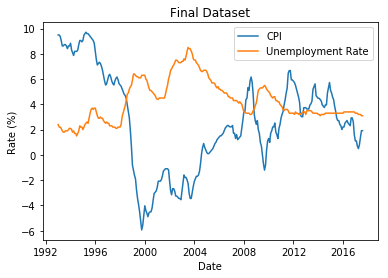

In [9]:
# Magic command for making matplotlib inline in jupyter notebook
%matplotlib inline

# Import matplotlib library
import matplotlib
import matplotlib.pyplot as plt

cpi = df_clean['cpi_yearly']
unemployment_rate = df_clean['Unemployment Rate']
# Date as X-axis
date = df_clean['Date']
# Plot
plt.plot(date,cpi, label='CPI')
plt.plot(date,unemployment_rate, label='Unemployment Rate')
# Display Setting
plt.title('Final Dataset')
plt.xlabel('Date')
plt.ylabel('Rate (%)')
plt.legend()

plt.show()


From the plot above, it seems that a negative relationship exists between inflation rate and unemployment rate.

## Data Analysis

### Summary Statistics

In [10]:
# Showing summary statistics
summary = df_clean.describe()
# Calculate Coefficient of Variation for each data series
summary.loc['cv'] = [summary[key]['std']/summary[key]['mean'] for key in list(summary.keys())]

summary

,cpi_yearly,Unemployment Rate
count,296.000000,296.000000
mean,2.609163,4.238851
std,3.853105,1.632014
min,-5.938056,1.500000
25%,0.174875,3.275000
50%,2.515659,3.600000
75%,5.451625,5.300000
max,9.706280,8.500000
cv,1.476759,0.385013


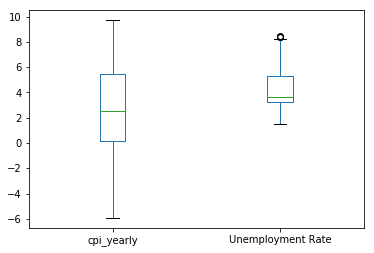

In [89]:
# Show box plot
fig, ax = plt.subplots()
df_clean.boxplot(ax=ax, grid=False)
plt.show()

According to the generated summary above, the inflation rate in Hong Kong in the past 25 years has a higher degree of dispersion (1.48) than that of unemployment rate (0.39).

### Scattered Plot

As the first step, a scattered plot is used to display the relationship between unemployment rate and inflation rate.

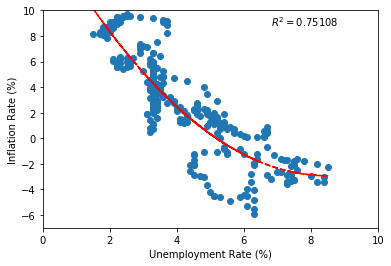

In [47]:
import scipy.stats as stats
# For code reuse later
def plot_scatter(x, y, fig_num):
    plt.figure(num=fig_num)
    # Get Scattered Plot
    plt.scatter(x, y)

    # Get best-fitting curve with degree 2
    z = np.polyfit(x,y,2)
    f = np.poly1d(z)
    y_hat = f(x)

    plt.plot(x, y_hat, 'r--')

    # Calculate R square
    y_bar = np.sum(y)/len(y)
    RSS = np.sum((y_hat-y_bar)**2)
    TSS = np.sum((y-y_bar)**2)
    plt.text(np.max(x)*0.8,np.max(y)*0.9,r"$R^2 = $" + str(round(RSS/TSS,5)))
    
    plt.xlim((0,10))
    plt.ylim((-7,10))
    plt.ylabel('Inflation Rate (%)')
    plt.xlabel('Unemployment Rate (%)')
    
    
plot_scatter(unemployment_rate,cpi,221)
plt.show()

From the graph above, the degree-3 polynomial curve fits the data quite well, explaining over 75% of the total variation.

Next, the relationship between these two variables in different periods is studied.

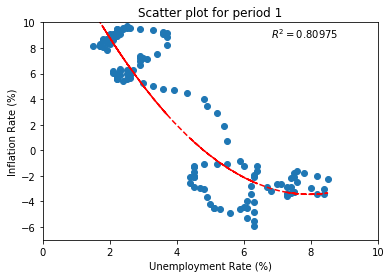

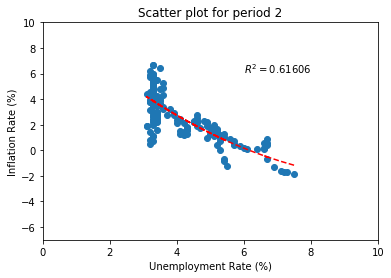

In [91]:
df_clean_list = []
unemployment_rate_list = []
cpi_list = []
# Split the dataset into 2 subsets (on or before 2003, after 2003)
df_clean_list.append(df_clean[df_clean['Date']<=datetime.date(2003,12,31)])
df_clean_list.append(df_clean[df_clean['Date']>datetime.date(2003,12,31)])

# Plot two charts
for idx, df in enumerate(df_clean_list):
    plot_scatter(df['Unemployment Rate'], df['cpi_yearly'], 222+idx)
    plt.title('Scatter plot for period ' + str(idx+1))
plt.show()


The scatter plots show that after 2003, the relationship between inflation rate and unemployment rate becomes less significant ($R^2$ drops from 0.81 to 0.62). In period 2 (after 2003), most of the variations come from the left. One possible explanation to this phenomenon is that the natural rate of unemployment during period 2 is near 3%, the increase in inflation rate cannot further reduce the unemployment rate.

### Correlation Plot

The cross-correlation plot of inflation rate and unemployment rate is produced to determine which type of indicators (lagging, coincident, leading) unemployment rate is for inflation rate.

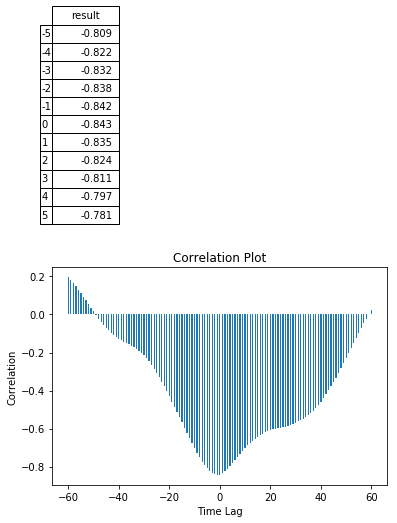

In [83]:
# normalize the arrays before using np.correlate to get normalized cross-correlation
# Source: Numpy issue #2310
# https://github.com/numpy/numpy/issues/2310
norm_cpi = (cpi-np.mean(cpi)) / (np.std(cpi) * len(cpi))
norm_unemployment_rate = (unemployment_rate-np.mean(unemployment_rate)) / (np.std(unemployment_rate))
result = np.correlate(norm_unemployment_rate,norm_cpi, mode='full')
index = range(-len(cpi)+1,len(cpi))

df = pd.DataFrame()
df['result'] = result
df['t'] = index
df = df.set_index('t')

# Show 5 years lag/lead correlations
df_plt = df.loc[-60:60]
plt.bar(df_plt.index,df_plt['result'],width=0.5)
plt.ylabel('Correlation')
plt.xlabel('Time Lag')
plt.title('Correlation Plot')
df_tab = df.loc[-5:5].apply(lambda x : round(x,3))
plt.table(cellText = df_tab.values,rowLabels = df_tab.index, bbox=[0,1.2,0.2,1], colLabels=df_tab.columns)
plt.show()


Since year-on-year inflation rate is used for each month, the correlation plot is smooth. However, from the plot, inflation rate and unemployment rate shows strongest relationship around time lag 0. This suggests that unemployment rate is a coincident indicator of inflation rate.

## Conclusion